In [1]:
import pandas as pd
# the metadata for this tutorial can be found on two csv files, metadata.csv and meta_cluster.csv
# these lines of code load and concatenate the two source files
df = pd.read_csv("metadata.csv")
df_cluster = pd.read_csv("meta_cluster.csv", dtype={'cluster_id': str})

# pd.concat() allows us concatenate the csvs using rules or logic
# in this case, axis= 0 means to join by rows instead of the columns, to sort the results, and to fill nan values with 0
# the last part is important because meta_cluster.csv has a column for cluster_id and metadata.csv does not
# see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
df_all = pd.concat([df,df_cluster], axis=0, ignore_index=True, sort=True).fillna('none')
df_all

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year
0,none,7,1,4fc03b9245c1498b0d1e86aa,https://timesmachine.nytimes.com/timesmachine/...,none,101702107,1905
1,none,7,1,4fc0532945c1498b0d250e4c,https://timesmachine.nytimes.com/timesmachine/...,m,101702142,1905
2,none,7,1,4fc045fc45c1498b0d2162b6,https://timesmachine.nytimes.com/timesmachine/...,m,101702170,1905
3,none,7,1,4fc0532945c1498b0d250e51,https://timesmachine.nytimes.com/timesmachine/...,none,101702169,1905
4,none,7,1,4fc03b9245c1498b0d1e86ad,https://timesmachine.nytimes.com/timesmachine/...,m,101702168,1905
...,...,...,...,...,...,...,...,...
3213,3,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,none,113314527,1920
3214,4,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,m,113314527,1920
3215,5,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,m,113314527,1920
3216,6,17,10,4fc0934a45c1498b0d37d0e6,https://timesmachine.nytimes.com/timesmachine/...,m,113314527,1920


In [770]:
from datetime import datetime as dt
import time

def s(date): # returns seconds since epoch
    return time.mktime(date.timetuple())
    
def toYearDecimal(row):   
    y = row['year']
    m = row['month']
    d = row['day']
    date_object = dt(year=y, month=m, day=d)
    year = date_object.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date_object) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date_object.year + fraction

df_all = df_all.dropna(subset=['day', 'month', 'year']).reset_index(drop=True)
df_all = df_all.loc[df_all['year'] != 1905]
df_all = df_all.loc[df_all['year'] != 1925]
df_all['yearDecimal'] = df_all.apply(toYearDecimal, axis=1).reset_index(drop=True)


In [138]:
# load term frequencies from csv files, convert to list of dictionaries
# loop metadata 
list_of_dictionaries = []
for row in df_all.iterrows():
    if row[1]['cluster_id'] == 'none':
        # if there's no numerican cluster id, build the file name using only the folder location, the id, and '.csv'
        # note that this code may need to be edited for windows machines
        txt_file_name = ''.join(['term-frequency-tables/', row[1]['nyt_id'], '.csv'])
        #print(txt_file_name)
    else:
        # if there's a numerican cluster id, build the file name with the folder location, the id, a hyphen, the cluster_id, and '.csv' number
        # note that this code may need to be edited for windows machines
        txt_file_name = ''.join(['term-frequency-tables/', row[1]['nyt_id'], '-', 

        row[1]['cluster_id'], '.csv'])

    # loading a csv as a pandas dataframe is often the fastest way to get data into python
    df = pd.read_csv(txt_file_name).dropna().reset_index(drop=True)

    # but I want a dictionary that looks like this:
    # mydict = {'the': 20,'of': 9,'and': 8,'poems': 6 ... }
    # this is a format scikit learn is designed to read
    #mydict = dict(zip(list(df['term']), list(df['count'])))
    df = df.set_index('term')
    #mydict = df.to_dict(orient='dict')['count']
    mydict = df['count'].to_dict()

    # list() turns each column to a list, zip() takes the two lists and makes a list of tuples, like this:
    # [('the', 20),('of', 9),('and', 8),('poems', 6) ... ]
    # and dict() converts that list of tuples to a dictionary

    # finally, now that I have the right format, I add this dictionary to end of my list of dictionaries
    list_of_dictionaries.append(mydict)
# len() of list_of_dictionaries will be the same as the number of reviews in binary, and the ame order
len(list_of_dictionaries)

1683

In [673]:
todays = []
for d in list_of_dictionaries:
    try:
        todays.append(d['today'])
        
    except:
        todays.append(0)
df_all['today'] = todays
today_by_year = df_all.groupby('year').mean().drop(['day', 'month',	'xml_id', 'yearDecimal'], axis=1).reset_index(drop=False)


In [674]:
today_by_year

,year,today
0,1906,0.022472
1,1907,0.014706
2,1908,0.036145
3,1909,0.016393
4,1910,0.000000
5,1911,0.000000
6,1912,0.000000
7,1913,0.024390
8,1914,0.178947
9,1915,0.250000


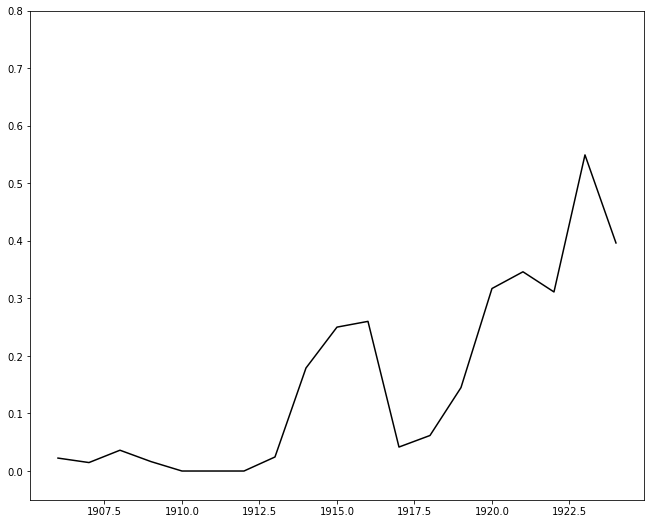

In [675]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(11,9))
plt.ylim(-0.05, 0.8)
#plt.xlim(1906, 1925)
#sns.scatterplot(x=results_df['actual'], y=results_df['predicted'], alpha=0.2)
#plt.scatter(today_by_year['today'], today_by_year['year'])
plt.plot(today_by_year['year'], today_by_year['today'], color='black')
#plt.title("Title")
#plt.ylabel('LabelY')
#plt.xlabel('LabelX')

#plt.subplots_adjust(top=0.85)

#plt.savefig('predicted_actual.png')

In [139]:
date_labels = df_all['yearDecimal']

In [148]:
# get N most frequent words (eg 1500)
from collections import Counter 
def top_words(number, list_of_dicts):
    totals = {}
    for d in list_of_dicts:
        for k,v, in d.items():
            try:
                totals[k] += v
            except: 
                totals[k] = v
    totals = Counter(totals)
    return [i[0] for i in totals.most_common(number)]
top_term_list = top_words(10000, list_of_dictionaries)     
# delete this cell for lesson

In [149]:
# convert dictionaries to only those words 
def cull_list_of_dicts(term_list, list_of_dicts):
    results = []
    for d in list_of_dicts:
        result = {}
        for term in term_list:
            try:
                result[term] = d[term]
            except:
                pass 
        results.append(result)
    return results
new_list_of_dicts = cull_list_of_dicts(top_term_list, list_of_dictionaries)
len(new_list_of_dicts)

1683

In [687]:
# import various from scikit learn
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# most frequent in corpus?

# set up logistic regression with gender labels
v = DictVectorizer()
X = v.fit_transform(new_list_of_dicts)

tfidf = TfidfTransformer()
Z = tfidf.fit_transform(X)

In [688]:
X

<1683x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 657664 stored elements in Compressed Sparse Row format>

In [689]:
Z.toarray()[0][:20]

array([0.07979885, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [690]:
#Z.shape
features = SelectKBest(f_regression, k=3500).fit(Z, date_labels)

In [691]:
selected = features.get_support()
selected

array([ True,  True, False, ..., False, False, False])

In [692]:
selected = features.get_support()
features_df = pd.DataFrame()
features_df['term'] = v.feature_names_
#features_df['select_score'] = features.scores_
#features_df['p'] = features.pvalues_
features_df['selected'] = selected
features_df = features_df.loc[features_df['selected'] == True]


In [693]:
from sklearn.feature_selection import SelectKBest, f_regression
#Z_new = SelectKBest(f_regression, k=3500).fit_transform(Z, date_labels)
Z_new = features.transform(Z)
Z_new = pd.DataFrame.sparse.from_spmatrix(Z_new)

In [694]:
from sklearn.model_selection import train_test_split
# split the rows into training data, training labels, test data, and test labels
# test on 33% of the data
X_train, X_test, y_train, y_test = train_test_split(Z_new, date_labels, test_size=0.10, random_state=91)
type(X_train)
#, X_test, y_train, y_test

pandas.core.frame.DataFrame

In [695]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

# fit the model to the training data
lr.fit(X_train, y_train)

# make label predictions
results = lr.predict(X_test)

In [696]:
lr.intercept_

1913.4448030078665

In [710]:
features = SelectKBest(f_regression, k=3500).fit(Z, date_labels)
selected = features.get_support()
features_df = pd.DataFrame()
features_df['term'] = v.feature_names_
#features_df['select_score'] = features.scores_
#features_df['p'] = features.pvalues_
features_df['selected'] = selected
features_df = features_df.loc[features_df['selected'] == True]
features_df['coef'] = lr.coef_
coefficients = features_df.sort_values(by='coef', ascending=False).reset_index(drop=True)
coefficients.iloc[0:25].to_csv('top_25.csv')

In [711]:
coefficients.iloc[-25:].to_csv('bottom_25.csv')

In [699]:
len(results)

169

In [700]:
def r_square(true, predicted):
    # substract each predicted value from each true
    residuals = [a - b for a, b in zip(true, predicted)]
    # calculate the sum of squared differences between predicted and true 
    ssd = sum([i**2 for i in residuals])
    # calculate the mean true value
    mean_diff = (sum(true))/len(true)
    # calculate the sum of squared differences of each true value minus the mean true value
    tss = sum([(i-mean_diff)**2 for i in true])
    # calculate final r2 value
    return 1-(ssd/tss)
r_square(list(y_test), list(results))


0.44081840147143025

In [701]:
from sklearn.metrics import r2_score
a = r_square(list(y_test), list(results))
b = r2_score(list(y_test), list(results))
a-b


3.3306690738754696e-16

In [702]:
results_df = pd.DataFrame()
results_df['predicted'] = list(results)
results_df['actual'] = list(y_test)
results_df['residual'] = results_df['predicted'] - results_df['actual']
results_df = results_df.sort_values(by='residual', ascending=False).reset_index(drop=True)
results_df.describe()

,predicted,actual,residual
count,169.000000,169.000000,169.000000
mean,1917.276958,1917.428992,-0.152034
std,5.815610,5.669469,4.236798
min,1894.024129,1906.013699,-13.399405
25%,1912.849458,1912.647541,-3.067451
50%,1917.948008,1918.799886,-0.484037
75%,1921.142702,1922.671119,2.491212
max,1932.678418,1924.950820,13.878532


In [703]:
results_df.loc[results_df['predicted'] <= 1907].reset_index(drop=True)

,predicted,actual,residual
0,1906.681390,1908.524590,-1.843200
1,1903.506350,1907.106849,-3.600499
2,1894.024129,1907.106849,-13.082720
3,1898.616989,1912.016393,-13.399405


In [705]:
results_df.loc[(results_df['residual'] <= 5) & (results_df['residual'] >= 0)].reset_index(drop=True)
# 55 under 5 56 under 5
# 74 between 0 and -5
# 139 total

# 40 greater than 5, -5
40/179

0.22346368715083798

In [706]:
from scipy import stats
stats.shapiro(results_df['residual'])
# W of 98.8 and p-value of .16
# W of 0.9920141696929932, pvalue=0.47351208329200745

ShapiroResult(statistic=0.9880117774009705, pvalue=0.1603146195411682)

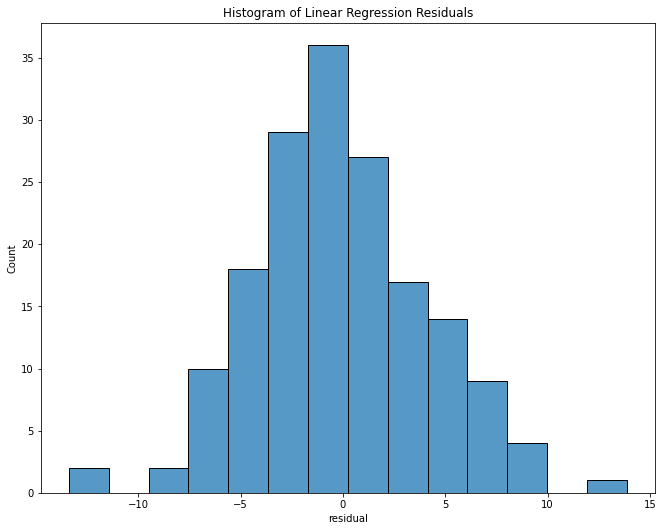

In [707]:
#residuals 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(11,9))

# plot residuals
hist = sns.histplot(data=results_df['residual'])
plt.title("Histogram of Linear Regression Residuals")
plt.subplots_adjust(top=0.85)
#plt.savefig('hist.png')

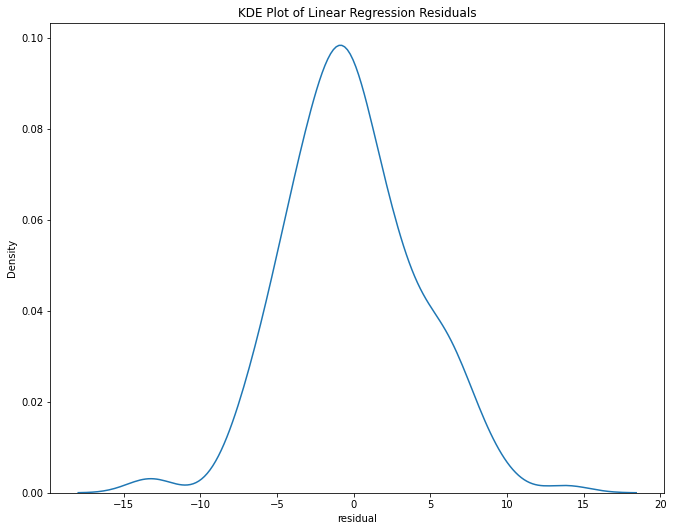

In [708]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(11,9))
dist = sns.kdeplot(ax=ax, data=results_df['residual'])
plt.title("KDE Plot of Linear Regression Residuals")
plt.subplots_adjust(top=0.85)
#plt.savefig('dist.png')

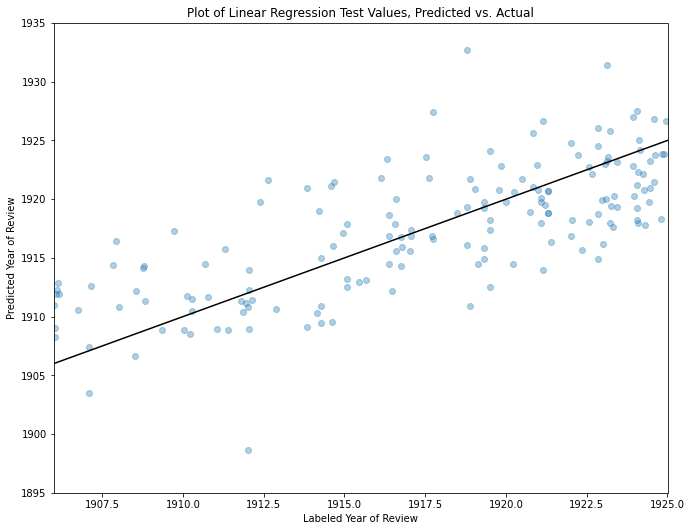

In [709]:
# evaluate homoscedasticity
import matplotlib.pyplot as plt
plt.figure(figsize=(11,9))
plt.ylim(1895, 1935)
plt.xlim(1906, 1925)
#sns.scatterplot(x=results_df['actual'], y=results_df['predicted'], alpha=0.2)
plt.scatter(results_df['actual'], results_df['predicted'], alpha=.35)
plt.plot([1895, 1935], [1895, 1935], color='black')

plt.title("Plot of Linear Regression Test Values, Predicted vs. Actual")
plt.ylabel('Predicted Year of Review')
plt.xlabel('Labeled Year of Review')

plt.subplots_adjust(top=0.85)

#plt.savefig('predicted_actual.png')

#plt.show()

In [771]:
#df_all
def get_hits(term):
    all_hits = []
    for d in list_of_dictionaries:
        try:
            hits = d[term]
        except:
            hits = 0
        all_hits.append(hits)
    return all_hits

In [772]:
df_all['di'] = get_hits('di')
df_all['garibaldi'] = get_hits('garibaldi')
df_all['mitchell'] = get_hits('mitchell')
df_all['emma'] = get_hits('emma')
df_all['hoy'] = get_hits('hoy')

df_all.loc[df_all['di'] !=0]

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year,yearDecimal,today,di,garibaldi,mitchell,emma,hoy
49,none,17,2,4fc0550a45c1498b0d259d00,https://timesmachine.nytimes.com/timesmachine/...,m,101767124,1906,1906.128767,0,1,0,0,0,0
106,none,30,3,4fc0564045c1498b0d25f267,https://timesmachine.nytimes.com/timesmachine/...,m,106707081,1907,1907.241096,0,1,0,0,0,0
109,none,13,4,4fc04e0345c1498b0d23ab7b,https://timesmachine.nytimes.com/timesmachine/...,none,106747728,1907,1907.279452,0,1,0,0,0,0
112,none,18,5,4fc048e145c1498b0d2243ba,https://timesmachine.nytimes.com/timesmachine/...,f,106753277,1907,1907.375342,0,1,0,0,0,0
119,none,13,7,4fc0563a45c1498b0d25e9d0,https://timesmachine.nytimes.com/timesmachine/...,m,106710570,1907,1907.528767,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620,5,3,3,4fc06cf545c1498b0d2c7532,https://timesmachine.nytimes.com/timesmachine/...,m,102676346,1918,1918.167123,0,1,0,0,0,0
1630,2,31,3,4fc0726345c1498b0d2e393f,https://timesmachine.nytimes.com/timesmachine/...,f,102685052,1918,1918.243836,0,1,0,0,0,0
1631,3,31,3,4fc0726345c1498b0d2e393f,https://timesmachine.nytimes.com/timesmachine/...,m,102685052,1918,1918.243836,0,1,0,0,0,0
1666,1,9,11,4fc078eb45c1498b0d3033cc,https://timesmachine.nytimes.com/timesmachine/...,m,118179609,1919,1919.854795,0,1,0,0,0,0


In [773]:
df_all.loc[df_all['garibaldi'] !=0]

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year,yearDecimal,today,di,garibaldi,mitchell,emma,hoy
386,none,21,12,4fc0627545c1498b0d296709,https://timesmachine.nytimes.com/timesmachine/...,m,100293066,1913,1913.969863,0,1,1,0,0,0
403,none,3,5,4fc06c8b45c1498b0d2c5674,https://timesmachine.nytimes.com/timesmachine/...,m,100088174,1914,1914.334247,0,1,1,0,0,0
578,none,22,8,4fc087ad45c1498b0d346d80,https://timesmachine.nytimes.com/timesmachine/...,f,113309911,1920,1920.639230,0,0,2,0,0,0
836,none,22,7,4fc08afb45c1498b0d3561f6,https://timesmachine.nytimes.com/timesmachine/...,m,105924328,1923,1923.553311,1,1,1,0,0,0
893,none,30,12,4fc096bd45c1498b0d38d973,https://timesmachine.nytimes.com/timesmachine/...,m,104977607,1923,1923.994521,0,0,3,0,0,0
930,none,16,3,4fc0b0ef45c1498b0d407b8b,https://timesmachine.nytimes.com/timesmachine/...,f,101584694,1924,1924.204918,0,0,2,0,0,0
1086,none,23,3,4fc08e2345c1498b0d364ed5,https://timesmachine.nytimes.com/timesmachine/...,f,98280877,1919,1919.221918,0,1,1,0,0,0


In [774]:
df_all.loc[df_all['mitchell'] !=0]

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year,yearDecimal,today,di,garibaldi,mitchell,emma,hoy
27,none,13,1,4fc0474945c1498b0d21c2eb,https://timesmachine.nytimes.com/timesmachine/...,m,101762706,1906,1906.032877,0,0,0,1,0,0
85,none,19,1,4fc0509645c1498b0d2455af,https://timesmachine.nytimes.com/timesmachine/...,f,104980510,1907,1907.049315,0,0,0,1,0,0
171,none,28,11,4fc050d745c1498b0d2471d8,https://timesmachine.nytimes.com/timesmachine/...,m,104814212,1908,1908.907104,0,0,0,1,0,0
230,none,19,2,4fc053d245c1498b0d253fa5,https://timesmachine.nytimes.com/timesmachine/...,none,105021727,1911,1911.134247,0,1,0,1,0,0
250,none,16,7,4fc0576345c1498b0d263e08,https://timesmachine.nytimes.com/timesmachine/...,m,104871476,1911,1911.536986,0,0,0,1,0,0
265,none,7,1,4fc058fd45c1498b0d26a9ff,https://timesmachine.nytimes.com/timesmachine/...,none,100579421,1912,1912.016393,0,0,0,1,0,0
321,none,12,1,4fc0635545c1498b0d29a33a,https://timesmachine.nytimes.com/timesmachine/...,m,100604867,1913,1913.030137,0,0,0,1,0,0
325,none,9,2,4fc07f0945c1498b0d320bb9,https://timesmachine.nytimes.com/timesmachine/...,m,100253474,1913,1913.106849,0,0,0,1,0,0
406,none,14,6,4fc06a5345c1498b0d2bb42a,https://timesmachine.nytimes.com/timesmachine/...,m,100320297,1914,1914.449315,1,0,0,1,0,0
416,none,23,8,4fc068e445c1498b0d2b425d,https://timesmachine.nytimes.com/timesmachine/...,m,104636042,1914,1914.641096,0,0,0,1,0,0


In [775]:
df_all.loc[df_all['hoy'] !=0]

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year,yearDecimal,today,di,garibaldi,mitchell,emma,hoy
287,none,12,5,4fc0660245c1498b0d2a6969,https://timesmachine.nytimes.com/timesmachine/...,m,100364605,1912,1912.360656,0,0,0,0,0,1
671,none,4,6,4fc07b7245c1498b0d3102e2,https://timesmachine.nytimes.com/timesmachine/...,f,99025725,1922,1922.421804,0,0,0,0,0,1
709,none,28,1,4fc0b0b345c1498b0d40668d,https://timesmachine.nytimes.com/timesmachine/...,f,105901204,1923,1923.073973,0,0,0,0,0,1
710,none,28,1,4fc08df045c1498b0d364551,https://timesmachine.nytimes.com/timesmachine/...,f,105901201,1923,1923.073973,5,0,0,0,0,1
751,none,18,3,4fc0942a45c1498b0d380f38,https://timesmachine.nytimes.com/timesmachine/...,m,105906049,1923,1923.208219,0,0,0,0,0,1
803,none,20,5,4fc090e945c1498b0d3714cd,https://timesmachine.nytimes.com/timesmachine/...,m,105863972,1923,1923.380708,0,0,0,0,0,1
854,none,9,9,4fc08f0245c1498b0d3692a5,https://timesmachine.nytimes.com/timesmachine/...,f,102057341,1923,1923.687557,1,0,0,0,0,1
866,none,14,10,4fc0903445c1498b0d36e6cb,https://timesmachine.nytimes.com/timesmachine/...,f,105932174,1923,1923.783562,0,0,0,0,0,1
869,none,28,10,4fc0903645c1498b0d36e8f1,https://timesmachine.nytimes.com/timesmachine/...,m,105934067,1923,1923.821918,0,0,0,0,0,1
1067,none,24,11,4fc084f745c1498b0d33a7ba,https://timesmachine.nytimes.com/timesmachine/...,m,97046341,1918,1918.895890,0,0,0,0,0,2


In [776]:
df_all.loc[df_all['emma'] !=0]

,cluster_id,day,month,nyt_id,nyt_pdf_endpoint,perceived_author_gender,xml_id,year,yearDecimal,today,di,garibaldi,mitchell,emma,hoy
625,none,27,2,4fc0772845c1498b0d2fb54f,https://timesmachine.nytimes.com/timesmachine/...,m,112673490,1921,1921.156164,2,0,0,0,3,0
626,none,27,2,4fc09e6e45c1498b0d3affb6,https://timesmachine.nytimes.com/timesmachine/...,m,112673500,1921,1921.156164,0,0,0,0,1,0
747,none,18,3,4fc0942a45c1498b0d380f68,https://timesmachine.nytimes.com/timesmachine/...,f,105906048,1923,1923.208219,0,0,0,0,5,0
863,none,7,10,4fc0960945c1498b0d38a315,https://timesmachine.nytimes.com/timesmachine/...,m,106011251,1923,1923.764384,1,0,0,0,1,0
965,none,25,5,4fc0979d45c1498b0d391955,https://timesmachine.nytimes.com/timesmachine/...,f,101599502,1924,1924.396061,0,0,0,0,2,0
972,none,1,6,4fc093f545c1498b0d37fe2e,https://timesmachine.nytimes.com/timesmachine/...,f,101600347,1924,1924.415187,0,0,0,0,3,0
989,none,20,7,4fc0828245c1498b0d330fb2,https://timesmachine.nytimes.com/timesmachine/...,m,98802298,1924,1924.549066,0,1,0,0,1,0
997,none,17,8,4fc0849a45c1498b0d339044,https://timesmachine.nytimes.com/timesmachine/...,m,101607263,1924,1924.625569,1,0,0,0,2,0
1436,1,22,10,4fc0576045c1498b0d2638f2,https://timesmachine.nytimes.com/timesmachine/...,none,105096572,1910,1910.805479,0,0,0,0,1,0


In [779]:
list_of_dictionaries[1436]['emma']

1

In [781]:
df_all.iloc[1436]['nyt_pdf_endpoint']

'https://timesmachine.nytimes.com/timesmachine/1910/10/22/105096572.pdf'